**Imports**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import saraRC1 as sara

import os
import sys

import deepgaze_pytorch

DEVICE = 'cuda'

In [2]:
IMG_DIR = '../ablation/images'
MASK_DIR = '../ablation/masks'

In [3]:
images = sorted([f for f in os.listdir(IMG_DIR) if f.endswith('.jpg')])
masks = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.png')])
names = []

with open(IMG_DIR + '/names.txt', 'r') as f:
    names = f.readlines()
    names = [x.strip() for x in names]

imgs = []
msks = []

for img in images:
    imgs.append(cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR, img)), cv2.COLOR_BGR2RGB))

    mask = cv2.imread(os.path.join(MASK_DIR, img.replace('.jpg', '.png')))
    msks.append(mask)

segments = {}

for img, mask, name in zip(imgs, msks, names):
    segments[name] = {}
    segments[name]['segments'] = []
    segments[name]['coordinates'] = []


    # Detect number of unique colors in the mask
    colors = np.unique(mask.reshape(-1, mask.shape[2]), axis=0)
    colors = [np.array(c) for c in colors]

    for i, color in enumerate(colors):
        if color[0] == 0 and color[1] == 0 and color[2] == 0:
            continue

        # Create a mask for the current color
        mask_color = cv2.inRange(mask, color, color)
        mask_color = cv2.cvtColor(mask_color, cv2.COLOR_GRAY2BGR)

        # Apply the mask to the image
        masked = cv2.bitwise_and(img, mask_color)

        # Find the bounding box of the mask
        gray = cv2.cvtColor(mask_color, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])

        # Coordinates tuple which is top left, bottom right
        coord_tup = (i, x, y, x+w, y+h)

        # Crop the image to the bounding box
        cropped = masked[y:y+h, x:x+w]

        # Append the cropped image to the list of segments
        segments[name]['segments'].append(cropped)

        # Append the coordinates to the list of coordinates
        segments[name]['coordinates'].append(coord_tup)


pairs = [
    (0, 2),
    (1, 3),
    (4, 6),
    (5, 7)
]

**Load Images**

In [4]:
p = 0

img_a, img_b = imgs[pairs[p][0]], imgs[pairs[p][1]]
name_a, name_b = names[pairs[p][0]], names[pairs[p][1]]
mask_a, mask_b = msks[pairs[p][0]], msks[pairs[p][1]]

In [5]:
def get_saliency_map(img, name, deepgaze_model):
    saliency_map = sara.return_saliency(img, generator='deepgaze', deepgaze_model=deepgaze_model, DEVICE='cuda')
    [sara_heatmap, text_overlay], sara_list = sara.return_sara(img.copy(), saliency_map=saliency_map, segments=segments[name]['segments'], coords=segments[name]['coordinates'], mode=2)

    overlay = img.copy()
    overlay = cv2.cvtColor(overlay, cv2.COLOR_RGB2RGBA)
    colormap = cv2.applyColorMap(sara_heatmap, cv2.COLORMAP_JET)
    colormap = cv2.cvtColor(colormap, cv2.COLOR_BGR2RGBA)

    sara_heatmap = cv2.cvtColor(sara_heatmap, cv2.COLOR_RGB2RGBA)
    sara_heatmap[:, :, 3] = np.where((sara_heatmap[:, :, :3] == [0, 0, 0]).all(axis=2), 0, 255)

    for i in range(3):
        sara_heatmap[:, :, i] = colormap[:, :, i]

    text_overlay = cv2.cvtColor(text_overlay, cv2.COLOR_RGB2RGBA)

    text_overlay[text_overlay[:, :, 0] < 192] = [0, 0, 0, 0]
    text_overlay[text_overlay[:, :, 0] >= 192, 3] = 255
    text_overlay = cv2.GaussianBlur(text_overlay, (3, 3), 0)
    shadow = cv2.GaussianBlur(text_overlay, (21, 21), 0)


    # text_overlay = cv2.GaussianBlur(text_overlay, (3, 3), 0)

    sara_heatmap_outline = sara_heatmap.copy()
    sara_heatmap_outline = cv2.cvtColor(sara_heatmap_outline, cv2.COLOR_RGBA2RGB)
    sara_heatmap_outline = cv2.Canny(sara_heatmap_outline, 100, 200)
    sara_heatmap_outline = cv2.cvtColor(sara_heatmap_outline, cv2.COLOR_GRAY2RGBA)
    
    return saliency_map, sara_heatmap, sara_list, text_overlay, sara_heatmap_outline, shadow

In [6]:
deepgaze_model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)

saliency_map_a, sara_heatmap_a, sara_list_a, text_overlay_a, sara_heatmap_outline_a, shadow_a = get_saliency_map(img_a, name_a, deepgaze_model)
saliency_map_b, sara_heatmap_b, sara_list_b, text_overlay_b, sara_heatmap_outline_b, shadow_b = get_saliency_map(img_b, name_b, deepgaze_model)

Loaded pretrained weights for efficientnet-b5


Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/matthewkenely/.cache/torch/hub/pytorch_vision_v0.6.0
/home/matthewkenely/Programming/Assignments/ICT3909 Final Year Project in Artificial Intelligence/ICT3909/saliency-ranking/saraRC1.py:119: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)


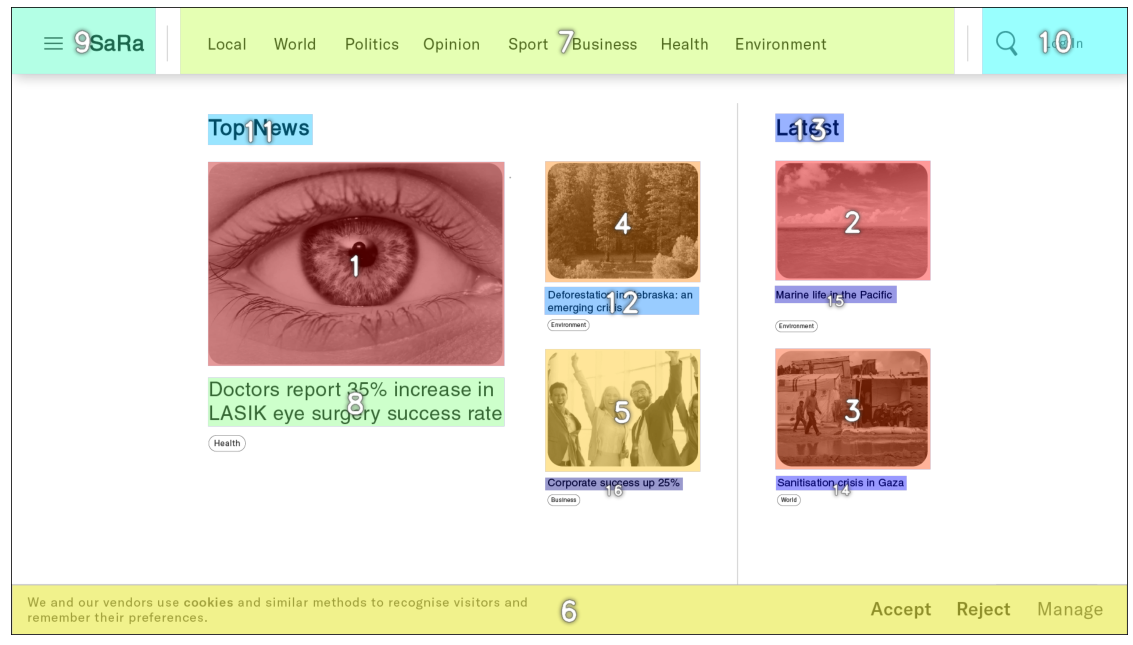

In [7]:
plt.figure(figsize=(20, 20))

plt.imshow(cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.imshow(sara_heatmap_a, alpha=0.4)
plt.imshow(shadow_a)
plt.imshow(text_overlay_a)

plt.xticks([]), plt.yticks([])

plt.show()

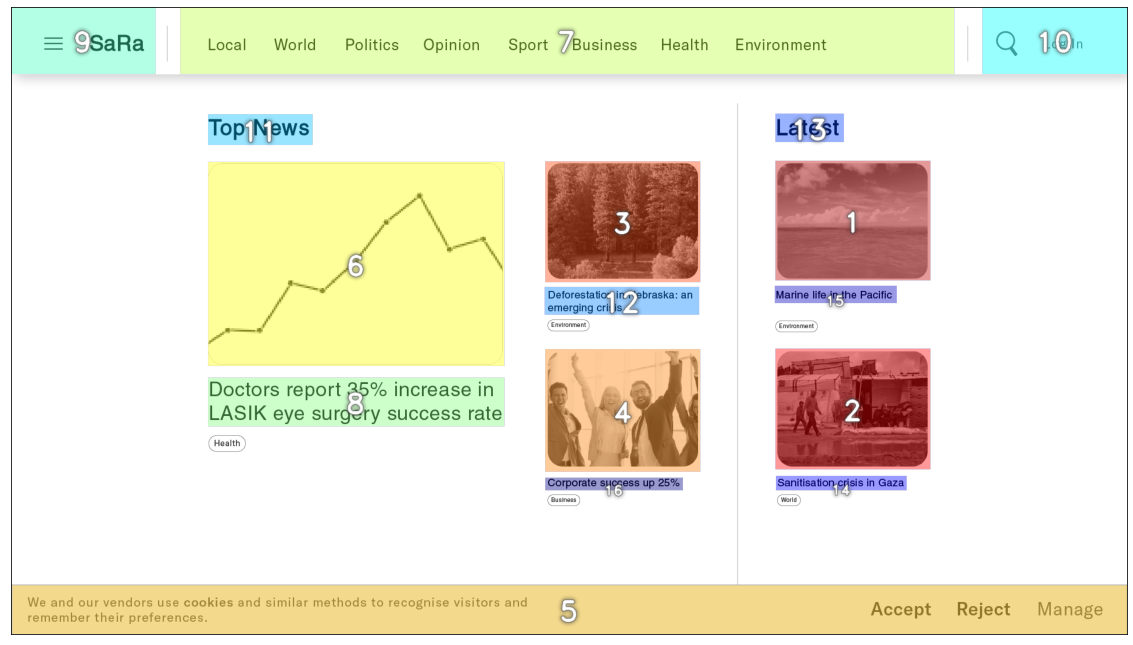

In [18]:
plt.figure(figsize=(20, 20))

plt.imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.imshow(sara_heatmap_b, alpha=0.4)
plt.imshow(shadow_b)
plt.imshow(text_overlay_b)

plt.xticks([]), plt.yticks([])



plt.show()

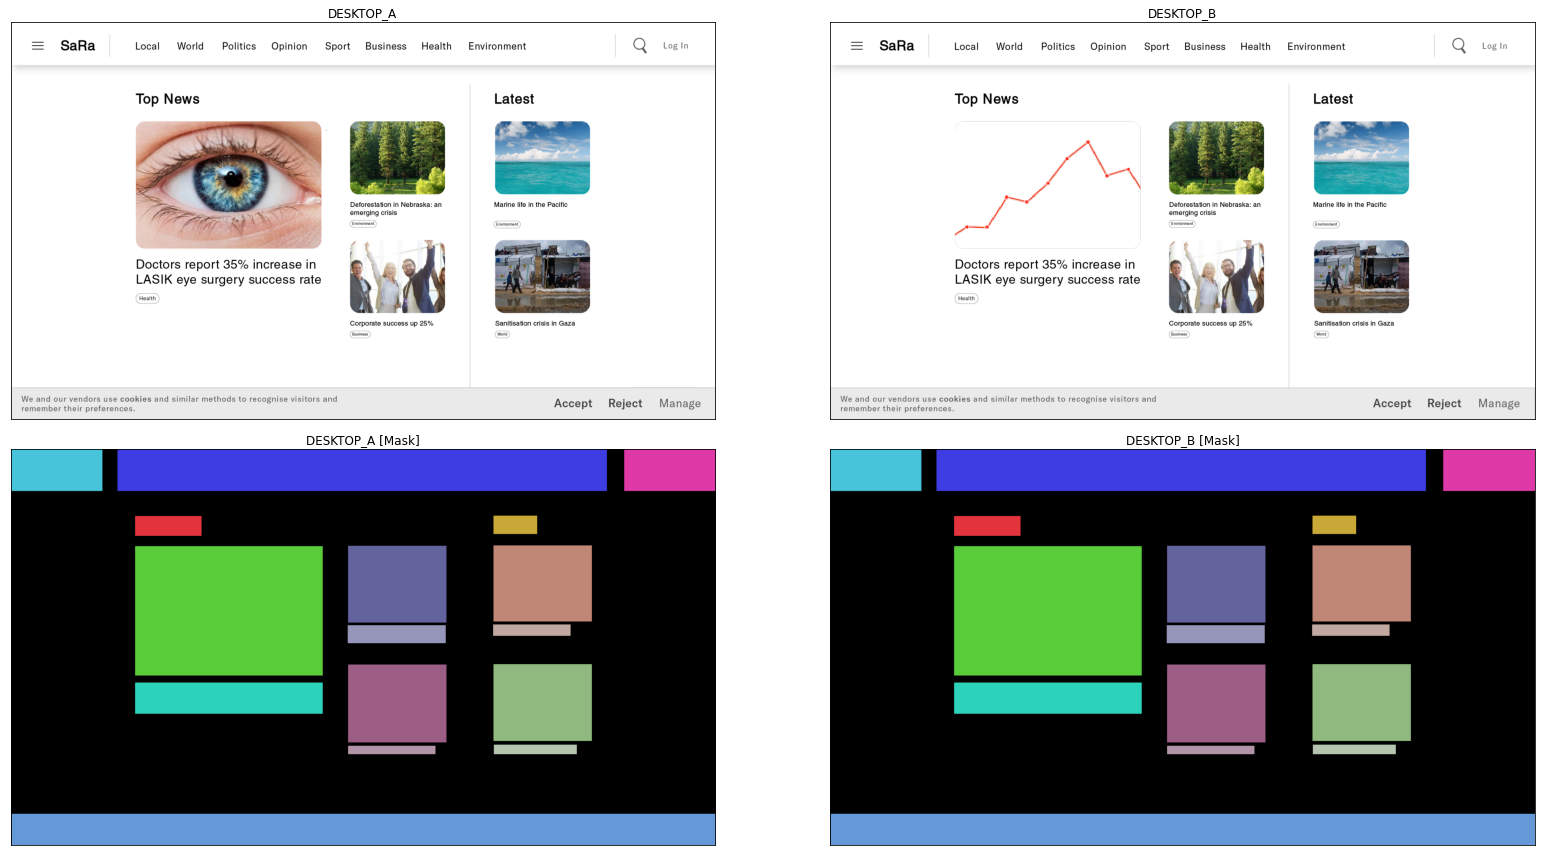

In [9]:
plt.figure(figsize=(24, 12))

plt.subplot(221)
plt.imshow(img_a)
plt.title(name_a)
plt.xticks([])
plt.yticks([])

plt.subplot(222)
plt.imshow(img_b)
plt.title(name_b)
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.imshow(mask_a)
plt.title(name_a + ' [Mask]')
plt.xticks([])
plt.yticks([])

plt.subplot(224)
plt.imshow(mask_b)
plt.title(name_b + ' [Mask]')
plt.xticks([])
plt.yticks([])


plt.tight_layout()
plt.show()

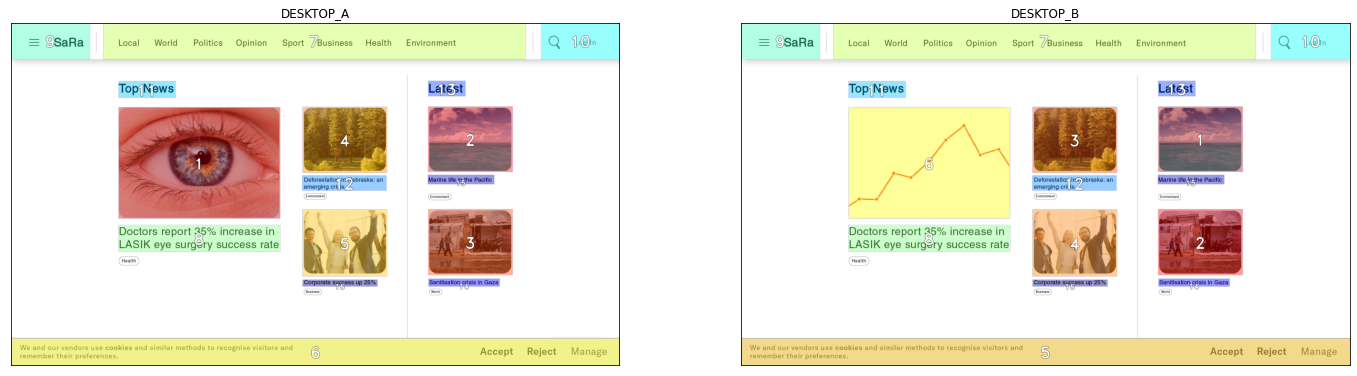

In [10]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(img_a)
plt.imshow(sara_heatmap_a, alpha=0.4)
plt.imshow(text_overlay_a)
plt.title(name_a)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(img_b)
plt.imshow(sara_heatmap_b, alpha=0.4)
plt.imshow(text_overlay_b)
plt.title(name_b)
plt.xticks([])
plt.yticks([])

plt.show()

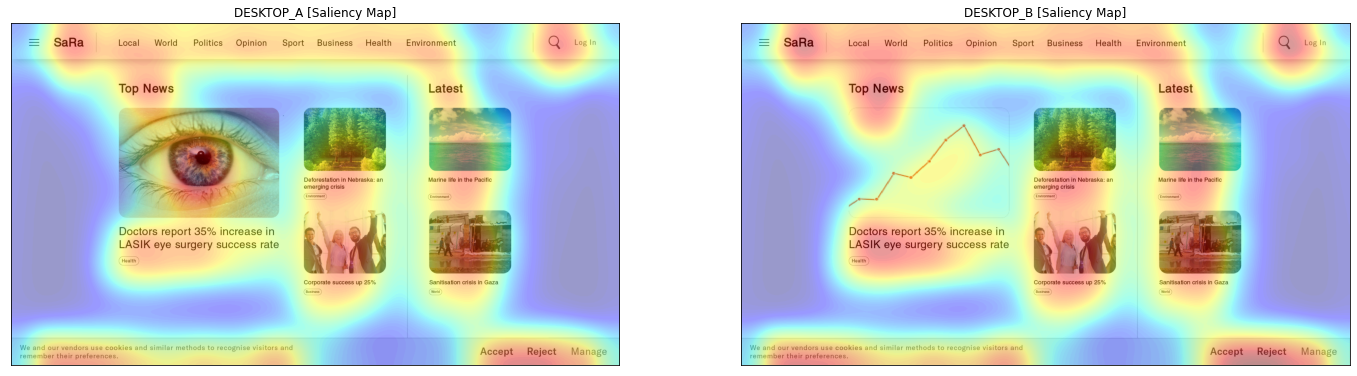

In [11]:
plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(img_a)
plt.imshow(saliency_map_a, alpha=0.4, cmap='jet')
plt.title(name_a + ' [Saliency Map]')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(img_b)
plt.imshow(saliency_map_b, alpha=0.4, cmap='jet')
plt.title(name_b + ' [Saliency Map]')
plt.xticks([]), plt.yticks([])

plt.show()

In [12]:
def index_to_coordinates(index, seg_dim, im_size):
    '''
    Given an index and a shape, this function returns the corresponding coordinates.
    '''

    x1 = int((index % seg_dim) * (im_size[1] / seg_dim))
    y1 = int((index // seg_dim) * (im_size[0] / seg_dim))

    x2 = int(x1 + (im_size[1] / seg_dim))
    y2 = int(y1 + (im_size[0] / seg_dim))
    
    return (x1, y1, x2, y2)

In [13]:
segments['DESKTOP_A']['coordinates']

[(1, 338, 638, 849, 723),
 (2, 290, 0, 1623, 117),
 (3, 0, 0, 249, 117),
 (4, 338, 267, 849, 619),
 (5, 918, 266, 1186, 475),
 (6, 1, 995, 1920, 1080),
 (7, 1314, 588, 1582, 797),
 (8, 917, 482, 1184, 531),
 (9, 918, 589, 1186, 801),
 (10, 918, 810, 1156, 833),
 (11, 1315, 807, 1541, 833),
 (12, 1314, 265, 1582, 472),
 (13, 1313, 480, 1524, 511),
 (14, 1314, 184, 1433, 234),
 (15, 1670, 0, 1920, 117),
 (16, 338, 185, 519, 239)]

In [14]:
segments['DESKTOP_B']['coordinates']

[(1, 338, 638, 849, 723),
 (2, 290, 0, 1623, 117),
 (3, 0, 0, 249, 117),
 (4, 338, 267, 849, 619),
 (5, 918, 266, 1186, 475),
 (6, 1, 995, 1920, 1080),
 (7, 1314, 588, 1582, 797),
 (8, 917, 482, 1184, 531),
 (9, 918, 589, 1186, 801),
 (10, 918, 810, 1156, 833),
 (11, 1315, 807, 1541, 833),
 (12, 1314, 265, 1582, 472),
 (13, 1313, 480, 1524, 511),
 (14, 1314, 184, 1433, 234),
 (15, 1670, 0, 1920, 117),
 (16, 338, 185, 519, 239)]

/home/matthewkenely/anaconda3/envs/sara/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
/home/matthewkenely/anaconda3/envs/sara/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
/home/matthewkenely/anaconda3/envs/sara/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: set_ticks() must have been called.


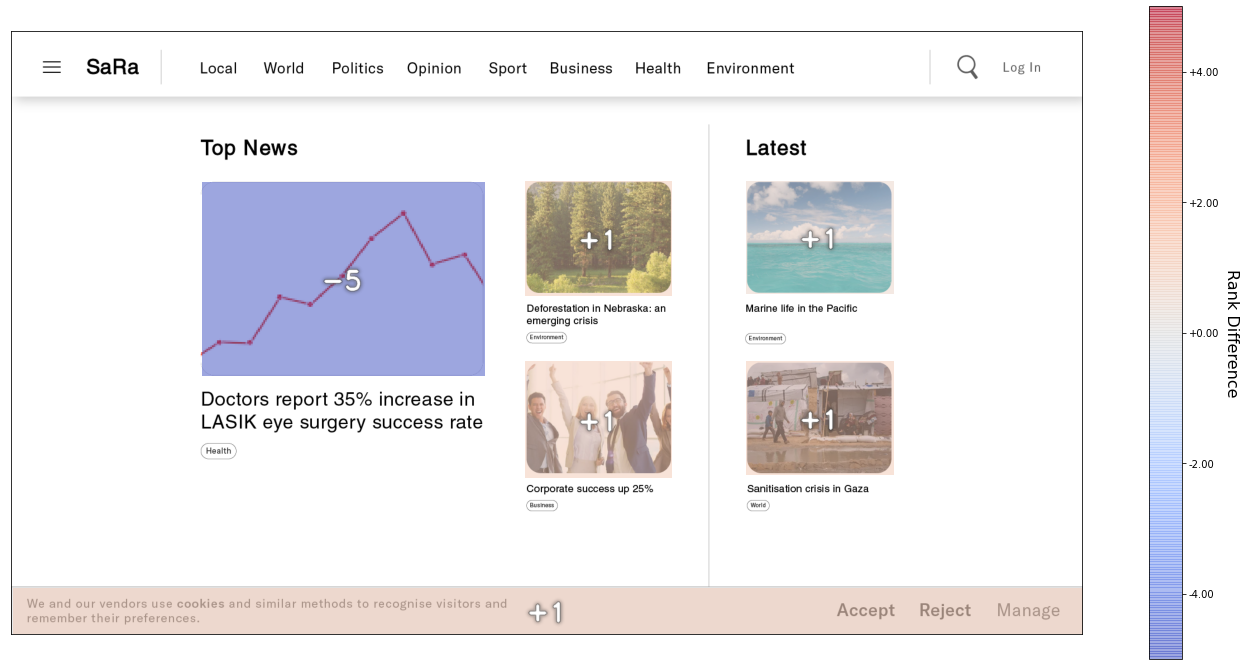

In [15]:
# Assuming sara_heatmap_a and sara_heatmap_b are your RGBA images
a_int16 = cv2.cvtColor(sara_heatmap_a, cv2.COLOR_RGBA2GRAY).astype(np.int16)
b_int16 = cv2.cvtColor(sara_heatmap_b, cv2.COLOR_RGBA2GRAY).astype(np.int16)
diff = a_int16 - b_int16

indices = sara_list_a

colormap_min = diff.min()
colormap_max = diff.max()
max_abs = max(abs(colormap_min), abs(colormap_max))

# Add a border to the diff image
diff_border = np.ones((diff.shape[0] + 2, diff.shape[1] + 2), dtype=diff.dtype) * max_abs
diff_border[1:-1, 1:-1] = diff
diff = diff_border

diff_qty = [i[1] - j[1] for i, j in zip(sorted(sara_list_a), sorted(sara_list_b))]

# Match the color values in diff to the actual differences in ranks
diff = cv2.normalize(diff, None, alpha=np.min(diff_qty), beta=np.abs(np.min(diff_qty)), norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Set up colormap with transparency for zero values
cmap = plt.get_cmap('coolwarm')
cmap.set_under('white')  # Set color for values less than vmin to white (fully transparent)
cmap.set_over('white')   # Set color for values greater than vmax to white (fully transparent)

# Show image B
plt.figure(figsize=(24, 12))
plt.imshow(img_b, alpha=1)
diff = cv2.resize(diff, (img_a.shape[1], img_a.shape[0]), interpolation=cv2.INTER_NEAREST)

# Show heatmap overlayed on top of image B
heatmap = plt.imshow(diff, cmap=cmap, alpha=0.5, vmin=np.min(diff), vmax=np.max(diff))
heatmap.set_array(np.ma.masked_where(diff == 0, diff))  # Mask zero values

# Plot the differences in text top left
diff_text = np.zeros((img_a.shape[0], img_a.shape[1]), dtype=np.uint8)
diff_text = cv2.cvtColor(diff_text, cv2.COLOR_BGR2RGBA)

for i, x1, y1, x2, y2 in segments['DESKTOP_A']['coordinates']:
    if diff_qty[i-1] != 0:
        # Calculate the center coordinates of the bounding box
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        # Determine the sign of diff_qty[i-1]
        sign = "+" if diff_qty[i-1] >= 0 else ""
        font_size = 1.6
        thickness = 3

        # Create the text to be displayed
        text_to_display = f'{sign}{diff_qty[i-1]}'

        # Get the size of the text
        (text_width, _), _ = cv2.getTextSize(text_to_display, cv2.FONT_HERSHEY_DUPLEX, font_size, thickness)

        # Calculate the position to center the text
        text_position = (center_x - text_width // 2, center_y + 20) 

        # Add the text to the image
        cv2.putText(diff_text, text_to_display, text_position, cv2.FONT_HERSHEY_DUPLEX, font_size, (255, 255, 255), thickness, cv2.LINE_AA)

# Set black regions to transparent
diff_text[diff_text[:, :, 0] < 192] = [0, 0, 0, 0]
diff_text[diff_text[:, :, 0] >= 192, 3] = 255
diff_text = cv2.GaussianBlur(diff_text, (3, 3), 0)
shadow = cv2.GaussianBlur(diff_text, (21, 21), 0)

plt.imshow(shadow, alpha=1)
plt.imshow(diff_text, alpha=1)

plt.xticks([]), plt.yticks([])

# Add a colorbar to the right of the image
cbar = plt.colorbar(heatmap, format='%+.2f')  # Use the format parameter to control decimal places

# Modify colorbar labels to include a plus sign for positive values
tick_labels = cbar.get_ticks()
tick_labels_str = [f'{label:+.2f}' if label >= 0 else f'{label:.2f}' for label in tick_labels]
cbar.set_ticklabels(tick_labels_str)

# Add cbar title "Rank Difference"
cbar.set_label('Rank Difference', labelpad=20, rotation=270, fontsize=16)

plt.show()


In [16]:
segments['DESKTOP_A']['coordinates']

[(1, 338, 638, 849, 723),
 (2, 290, 0, 1623, 117),
 (3, 0, 0, 249, 117),
 (4, 338, 267, 849, 619),
 (5, 918, 266, 1186, 475),
 (6, 1, 995, 1920, 1080),
 (7, 1314, 588, 1582, 797),
 (8, 917, 482, 1184, 531),
 (9, 918, 589, 1186, 801),
 (10, 918, 810, 1156, 833),
 (11, 1315, 807, 1541, 833),
 (12, 1314, 265, 1582, 472),
 (13, 1313, 480, 1524, 511),
 (14, 1314, 184, 1433, 234),
 (15, 1670, 0, 1920, 117),
 (16, 338, 185, 519, 239)]